# Домашнее задание 7

Это домашнее задание по материалам второго семинаров. Дедлайн по отправке - 23:55 7 апреля. 

Домашнее задание выполняется в этом же Jupyter Notebook'e и присылается мне на почту: __beznosikov.an@phystech.edu__.

Решение каждой задачи необходимо поместить после её условия.

Файл должен называться: Фамилия_Имя_Optimization_HW_7

При полном запуске Вашего решения (Kernel -> Restart & Run All) все ячейки должны выполняться без ошибок. 

## Задача 1

Рассмотрим 'распределенную' задачу минимизации:
\begin{equation}
\min_{x \in \mathbb{R}^d} f(x) = \frac{1}{n} \sum\limits_{i=1}^n f_i(x) = \frac{1}{2n} \sum\limits_{i=1}^n x^T A_i x - b^T_i x,
\end{equation}
где $n = 10$, в качестве матриц $\{A_i\}_{i=1}^n$ - случайные матрицы с $L =1000$, $\mu = 1$, $d = 100$, $\{b_i\}_{i=1}^n$ - так же случайные векторы.

__(а)__ Для такой задачи симулируем распределенное решение (вычисления на 1 компьютере, без распараллеливания). 
Реализуйте обычный распределенный градиентый спуск с операторами сжатия. Сжимайте информацию только от устройств к серверу. Используйте операторы сжатия $\text{Rand}1\%$, $\text{Rand}5\%$, $\text{Rand}10\%$, $\text{Rand}20\%$. Для каждого случая подберите шаг $\gamma$ для наилучшей сходимости, постройте сравнительный график сходимости (по оси $y$ - критерий $\| \nabla f(x^k)\|^2$, а по оси $x$ - число 'переданной информации' от устройств к серверу). Сделайте вывод.

In [1]:
import my_optimization as opt
import numpy as np

In [2]:
#generating the problem setting
args = {}
args['n_workers'] = 10
args['L'] = 1000
args['mu'] = 1
args['d'] = 100
args['seed'] = 40

np.random.seed(args['seed'])
args['A_list'] = [opt.gen_A(args['d'], args['mu'] , args['L']) for i in range(args['n_workers'])]
args['b_list'] = [np.random.rand(args['d']) for i in range(args['n_workers'])]
x_0    = np.random.random_sample(args['d'])

def d_f_quad(x, args):
    res = 0
    for i in range(args['n_workers']):
        res += 1./2 * x.T @ args['A_list'][i] @ x - args['b'][i] @ x
    return res / (2 * args['n_workers'])

def d_f_quad_grad(x, args):
    grad_list = []
    for i in range(args['n_workers']):
         grad_list.append(args['A_list'][i] @ x - args['b_list'][i])
    return grad_list

In [3]:
FLOAT_BYTES = 4

def best_compressor_alg(title, n_iter, compression_coeff, c_param_list, y_lim = 1e-2, rand_k_activate = False, 
                        top_k_activate = False, diana_activate = False, ef_activate = False):

    def check_gamma(k, f, grad_f, x_k, x_true, args):
            return args['c']/(4 * args['L'])

    k_param = int(args['d'] * compression_coeff)

    x, y, labels = [], [], []
    def best_gamma(k, f, grad_f, x_k, x_true, args):
        return c_param_list[0]/(4 * args['L'])

    best_alg = opt.GradientOptimizer(
                                    d_f_quad, d_f_quad_grad, x_0, criterium = '||grad_f(x_k)||', 
                                    args = args, n_iter = n_iter, gamma_k = best_gamma, n_workers = args['n_workers'],
                                    rand_k_activate = rand_k_activate, top_k_activate=top_k_activate,
                                    top_k_param = k_param, rand_k_param = k_param,
                                    y_lim = y_lim, diana_activate=diana_activate, ef_activate=ef_activate
                                    )
    best_points_arr, best_differences_arr, best_times_arr, best_acc_arr = best_alg.descent()
    best_information = [compression_coeff * FLOAT_BYTES * _ for _ in range(len(best_differences_arr))]

    idx, best_idx = 0, 0
    for args['c'] in c_param_list:    
        check_alg = opt.GradientOptimizer(
                                    d_f_quad, d_f_quad_grad, x_0, criterium = '||grad_f(x_k)||', 
                                    args = args, n_iter = n_iter, gamma_k = check_gamma, n_workers = args['n_workers'],
                                    rand_k_activate = rand_k_activate, top_k_activate=top_k_activate,
                                    top_k_param = k_param, rand_k_param = k_param,
                                    y_lim = y_lim, diana_activate=diana_activate, ef_activate=ef_activate
                                    )
        points_arr, differences_arr, times_arr, acc_arr = check_alg.descent()

        if (len(differences_arr) < len(best_differences_arr)): 
            best_alg = check_alg
            best_differences_arr = differences_arr
            best_information = [compression_coeff * FLOAT_BYTES * _ for _ in range(len(best_differences_arr))]
            best_idx = idx
            best_label = (title + r"Compressor-$%i \gamma = \frac{%f}{4L}$" % (k_param, args['c']))
        else:
             if differences_arr[-1] < best_differences_arr[-1]:
                best_alg = check_alg
                best_differences_arr = differences_arr
                best_information = [compression_coeff * FLOAT_BYTES * _ for _ in range(len(best_differences_arr))]
                best_idx = idx
                best_label = (title + r"Compressor-$%i \gamma = \frac{%f}{4L}$" % (k_param, args['c']))

        information = [compression_coeff * FLOAT_BYTES * _ for _ in range(len(differences_arr))]
        x.append(information)
        y.append(differences_arr)
        labels.append(title + r"-$%i \gamma = \frac{%f}{4L}$" % (k_param, args['c']))
        idx += 1

    best_idx_list = [best_idx]         
    return x, y, labels, best_alg, best_information, best_differences_arr, best_label, best_idx_list

In [4]:
#for the b)
X_compare, Y_compare, Labels_compare = [], [], []

100%|██████████| 1000/1000 [00:00<00:00, 1491.63it/s]


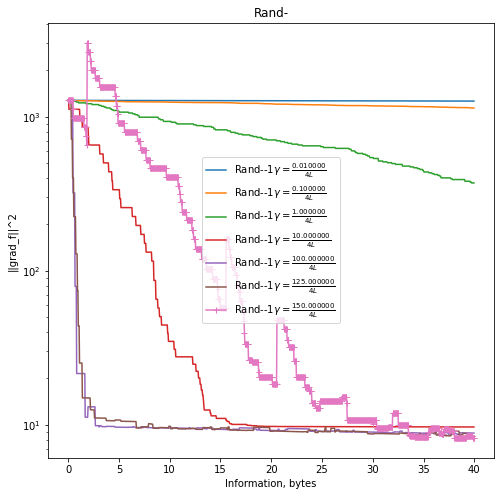

In [5]:
#LR fitting Rand1%
title = "Rand-"
n_iter = 1000
compression_coeff = 0.01
c_param_list =  [0.01, 0.1, 1, 10, 100, 125, 150]
x, y, labels, best_alg, best_information, best_differences_arr, best_label, best_idx = best_compressor_alg(title,
                                            n_iter, compression_coeff, c_param_list, y_lim = 1e0, 
                                            rand_k_activate = True, top_k_activate = False, diana_activate = False, 
                                            ef_activate = False
                                            )
opt.plot_graphs(x, y, x_label = "Information, bytes", lines_labels = labels, title = title, logscale = True, criteria_type = "||grad_f||^2", idx_marker_arr = best_idx)

In [6]:
X_compare.append(x[4])
Y_compare.append(y[4])
Labels_compare.append(labels[4])

### LR choice for Rand1%
- The function said that the best is when $c = 125$ (see the choice criteria 1), but I think the best is $c = 100$ because of stability

100%|██████████| 1000/1000 [00:00<00:00, 1248.07it/s]


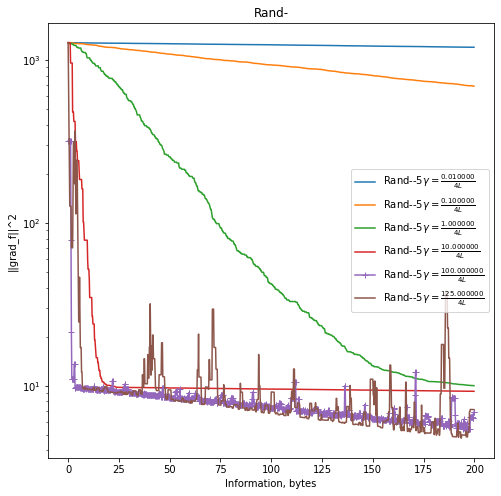

In [7]:
#LR fitting Rand5%
title = "Rand-"
n_iter = 1000
compression_coeff = 0.05
c_param_list =  [0.01, 0.1, 1, 10, 100, 125]
x, y, labels, best_alg, best_information, best_differences_arr, best_label, best_idx = best_compressor_alg(title, 
                                            n_iter, compression_coeff, c_param_list, y_lim = 1e0, 
                                            rand_k_activate = True, top_k_activate = False, diana_activate = False, 
                                            ef_activate = False
                                            )
opt.plot_graphs(x, y, x_label = "Information, bytes", lines_labels = labels, title = title, logscale = True, criteria_type = "||grad_f||^2", idx_marker_arr = best_idx)

In [8]:
X_compare.append(x[4])
Y_compare.append(y[4])
Labels_compare.append(labels[4])

### LR choice for Rand5%
- The function said that the best is when $c = 125$ (see the choice criteria 1), but I personally think the best is $c = 100$ because because it is fastest to converge

100%|██████████| 1000/1000 [00:00<00:00, 1068.25it/s]


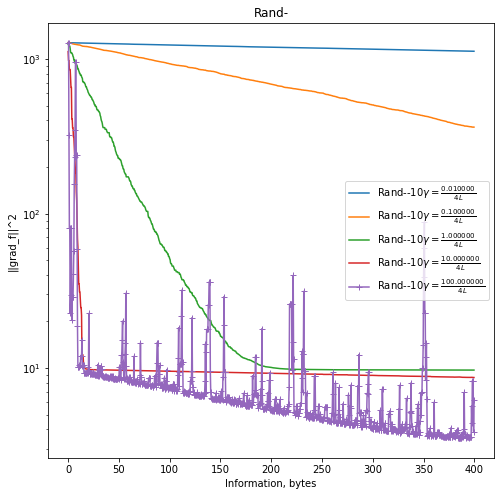

In [9]:
#LR fitting Rand10%
title = "Rand-"
n_iter = 1000
compression_coeff = 0.1
c_param_list =  [0.01, 0.1, 1, 10, 100]
x, y, labels, best_alg, best_information, best_differences_arr, best_label, best_idx = best_compressor_alg(title,
                                            n_iter, compression_coeff, c_param_list, y_lim = 1e0, 
                                            rand_k_activate = True, top_k_activate = False, diana_activate = False, 
                                            ef_activate = False
                                            )
opt.plot_graphs(x, y, x_label = "Information, bytes", lines_labels = labels, title = title, logscale = True, criteria_type = "||grad_f||^2", idx_marker_arr = best_idx)

In [10]:
X_compare.append(x[3])
Y_compare.append(y[3])
Labels_compare.append(labels[3])

### LR choice for Rand10%
- The function said that the best is when $c = 100$ (see the choice criteria 1), but I personally think the best is $c = 10$ because because it is stable than others, although not the fastest

100%|██████████| 1000/1000 [00:01<00:00, 924.88it/s]


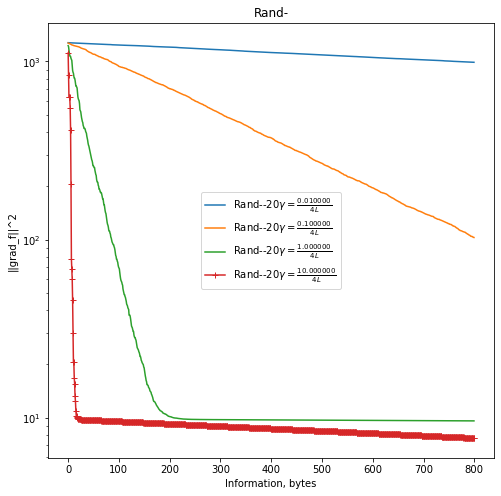

In [11]:
#LR fitting Rand20%
title = "Rand-"
n_iter = 1000
compression_coeff = 0.2
c_param_list = [0.01, 0.1, 1, 10]
x, y, labels, best_alg, best_information, best_differences_arr, best_label, best_idx = best_compressor_alg(title,
                                            n_iter, compression_coeff, c_param_list, y_lim = 1e0, 
                                            rand_k_activate = True, top_k_activate = False, diana_activate = False, 
                                            ef_activate = False
                                            )
opt.plot_graphs(x, y, x_label = "Information, bytes", lines_labels = labels, title = title, logscale = True, criteria_type = "||grad_f||^2", idx_marker_arr = best_idx)

In [12]:
X_compare.append(x[3])
Y_compare.append(y[3])
Labels_compare.append(labels[3])

### LR choice for Rand20%
- The function said that the best is when $c = 10$ (see the choice criteria 1) and I agree

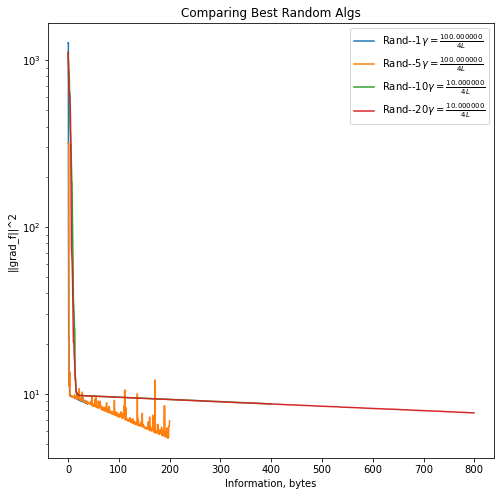

In [13]:
#Comparing them together
opt.plot_graphs(X_compare, Y_compare, x_label = "Information, bytes", lines_labels = Labels_compare, title = "Comparing Best Random Algs", logscale = True, criteria_type = "||grad_f||^2", idx_marker_arr = [])

### Conclusion
With the current theoretical learning rate the best result in terms of the speed and depth of convergence achieves Rand-5%, actually I don't have a clue why

The following statement I had for Rand-10%: it may be the best probably because the case is more independent (we have $d = 100, n = 10, k = 10$, so we choose the same coordinates less possibly and the overall coverage is pretty good)

__(б)__ Теперь будем использовать в качестве операторов сжатия $\text{Top}10\%$. Сжимайте информацию только от устройств к серверу. Используйте два метода: обычный распределенный градиентный спуск с операторами сжатия, также распределенный градиентный спуск с техникой компесации ошибки (error feedback - смотри Алгоритм 1 из [статьи](https://arxiv.org/abs/2002.12410)). Для каждого метода подберите шаг $\gamma$ для наилучшей сходимости, постройте сравнительный график сходимости (по оси $y$ - критерий $\| \nabla f(x^k)\|^2$, а по оси $x$ - число итераций/коммуникаций). Сделайте вывод.

In [14]:
X_compare, Y_compare, Labels_compare = [], [], []

100%|██████████| 2000/2000 [00:01<00:00, 1519.33it/s]


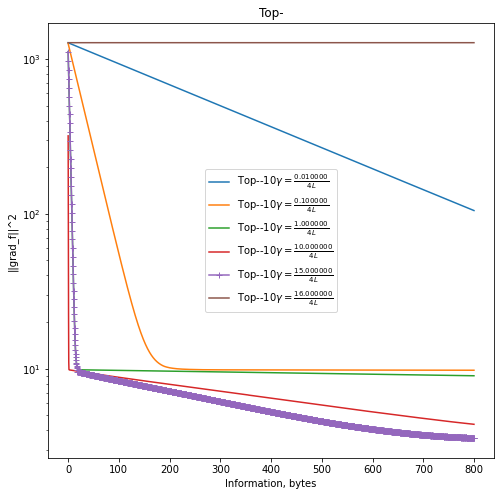

In [15]:
#LR fitting Top10%
title = "Top-"
n_iter = 2000
compression_coeff = 0.1
c_param_list = [0.01, 0.1, 1, 10, 15, 16] #16+ - divergence
x, y, labels, best_alg, best_information, best_differences_arr, best_label, best_idx = best_compressor_alg(title,
                                            n_iter, compression_coeff, c_param_list, y_lim = 1e-2, 
                                            rand_k_activate = False, top_k_activate = True, diana_activate = False, 
                                            ef_activate = False
                                            )
opt.plot_graphs(x, y, x_label = "Information, bytes", lines_labels = labels, title = title, logscale = True, criteria_type = "||grad_f||^2", idx_marker_arr = best_idx)

In [16]:
X_compare.append(x[4])
Y_compare.append(y[4])
Labels_compare.append(labels[4])

### LR choice for Top10%
- The function said that the best is when $c = 15$ (see the choice criteria 1) and I agree with this statement

100%|██████████| 1000/1000 [00:00<00:00, 2074.64it/s]


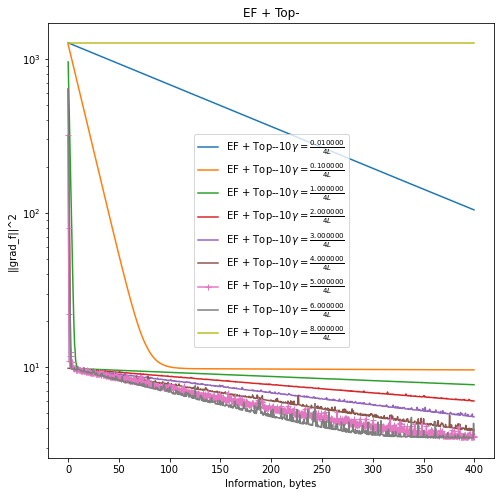

In [17]:
#LR fitting Top10%
title = "EF + Top-"
n_iter = 1000
compression_coeff = 0.1
c_param_list = [0.01, 0.1, 1, 2, 3, 4, 5, 6, 8] 
x, y, labels, best_alg, best_information, best_differences_arr, best_label, best_idx = best_compressor_alg(title,
                                            n_iter, compression_coeff, c_param_list, y_lim = 1e-2, 
                                            rand_k_activate = False, top_k_activate = True, diana_activate = False, 
                                            ef_activate = True
                                            )
opt.plot_graphs(x, y, x_label = "Information, bytes", lines_labels = labels, title = title, logscale = True, criteria_type = "||grad_f||^2", idx_marker_arr = best_idx)

In [18]:
X_compare.append(x[6])
Y_compare.append(y[6])
Labels_compare.append(labels[6])

### LR choice for Top10% + EF
- The function said that the best is when $c = 5$ (see the choice criteria 1) and I agree with this statement (but based on the plot $c = 6$ also fits)

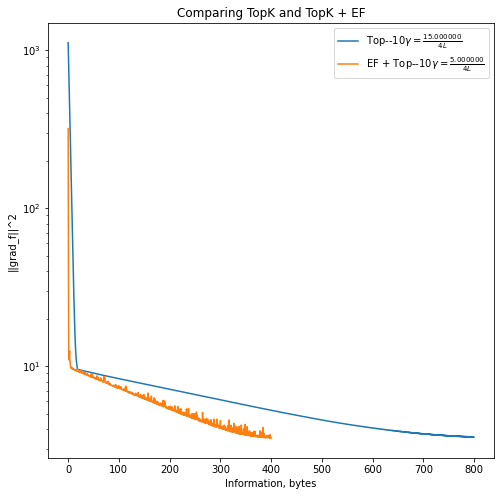

In [19]:
#Comparing them together
opt.plot_graphs(X_compare, Y_compare, x_label = "Information, bytes", lines_labels = Labels_compare, title = "Comparing TopK and TopK + EF", logscale = True, criteria_type = "||grad_f||^2", idx_marker_arr = [])

### Conclusion

So, the best error feedback mechanism helps to converge faster (and helps to basically converge)

## Задача 2

Рассмотрим задачу логистической регрессии на датасете mushrooms с $\ell_2$-регуляризацией (коэффициент регуляризации равен $\frac{L}{1000}$). 

__(а)__ Симмулируем распределенное решение. Для этого разделите обучающую выборку случайно и равномерно на $n=10$ частей. Каждая такая часть сформирует $f_i$.

In [20]:
#Data Preprocessing
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split
import numpy as np

dataset = "mushrooms.txt"

data = load_svmlight_file(dataset)
X, y = data[0].toarray(), data[1]
y = y * 2 - 3

args = {}
args['n'], args['d'] = X.shape[0], X.shape[1] 
args['n_workers'] = 10

args['X_train'], args['X_test'], args['y_train'], args['y_test'] = train_test_split(X, y, test_size=0.2, random_state=True)
x_0 = np.zeros(args['d'])
args['L'] = np.max(np.linalg.eigvals(1/(4*len(args['X_train'])) * args['X_train'].T @ args['X_train']))

def split_dataset(X_train, y_train, n):
    data = np.column_stack((X_train, y_train))
    np.random.shuffle(data)
    parts = np.array_split(data, n)
    X_parts = [part[:,:-1] for part in parts]
    y_parts = [part[:,-1].astype(int) for part in parts]
    return X_parts, y_parts

args['X_train_list'], args['y_train_list'] = split_dataset(args['X_train'], args['y_train'], args['n_workers'])

In [21]:
def d_logloss_mushrooms(w, args):
    ans = 0
    for i in range(len(args['X_train'])):
        ans += np.log(1 + np.exp(-(w @ args["X_train"][i]) * args["y_train"][i]))
    return ans / len(args["X_train"])

def d_logloss_grad_mushrooms (w, args):
    grad_list = []
    for j in range(args['n_workers']):
        n_samples = len(args['X_train_list'][j]) 
        
        grad_j = np.zeros(w.size) 

        for i in range(n_samples):
            grad_j -= np.real(args['y_train_list'][j][i] * args['X_train_list'][j][i] * np.exp(- w.dot(args['X_train_list'][j][i]) * args["y_train_list"][j][i]) / (1 + np.exp(- w.dot(args['X_train_list'][j][i]) * args['X_train_list'][j][i])))
        grad_j /= n_samples
        grad_list.append(grad_j)
        
    return grad_list

__(б)__ Реализуйте симмуляцию (как в Задаче 1) обычного распределенного градиентного спуска с операторами сжатия, распределенного градиентного спуска с техникой error feedback, алгоритма DIANA (смотри Алгоритм 11 из [статьи](https://arxiv.org/abs/1905.11261)). Сжатия происходят только при пересылке от сервера к устройствам.

__(в)__ Используйте операторы сжатия $\text{Top}10\%$ и $\text{Rand}10\%$ во всех трех методах (всего получается 6 разных подходов). Для каждого подхода подберите шаг $\gamma$ для наилучшей сходимости, постройте 2 сравнительных графика сходимости (по оси $y$ - критерий $\| \nabla f(x^k)\|^2$ или точность предсказаний, а по оси $x$ - число итераций/коммуникаций). Сделайте вывод.

In [22]:
X_crit, Y_crit, Labels_crit = [], [], []
X_acc, Y_acc, Labels_acc = [], [], []
specific_slice_num = 0

In [23]:
FLOAT_BYTES = 4

def best_compressor_alg_loss(loss, loss_gradient, func_title, n_iter, compression_coeff, c_param_list, y_lim = 1e-2, rand_k_activate = False, 
                        top_k_activate = False, diana_activate = False, ef_activate = False, ef21_activate = False, marina_activate = False, p_marina = 0.5):
    
    def log_acc(k, f, grad_f, x_k, x_true, args):
        corr_count = 0
        test_count = len(args['y_test'])
        for i in range(test_count):
            if args['X_test'][i].dot(x_k) * args['y_test'][i] > 0:
                corr_count += 1
        return corr_count / test_count

    def check_gamma(k, f, grad_f, x_k, x_true, args):
            return args['c']/(4 * args['L'])

    k_param = int(args['d'] * compression_coeff)

    x, y, labels, accs = [], [], [], []
    def best_gamma(k, f, grad_f, x_k, x_true, args):
        return c_param_list[0]/(4 * args['L'])

    best_alg = opt.GradientOptimizer(
                                    loss, loss_gradient, x_0, criterium = '||grad_f(x_k)||', 
                                    args = args, n_iter = n_iter, gamma_k = best_gamma, n_workers = args['n_workers'],
                                    rand_k_activate = rand_k_activate, top_k_activate=top_k_activate,
                                    top_k_param = k_param, rand_k_param = k_param,
                                    y_lim = y_lim, diana_activate=diana_activate, ef_activate=ef_activate, acc_k = log_acc, 
                                    ef21_activate=ef21_activate, marina_activate=marina_activate, p_marina=p_marina
                                    )
    best_points_arr, best_differences_arr, best_times_arr, best_acc_arr = best_alg.descent()
    best_information = [compression_coeff * FLOAT_BYTES * _ for _ in range(len(best_differences_arr))]
    best_label = 'No best alg yet'
    idx, best_idx = 0, 0
    for args['c'] in c_param_list:    
        check_alg = opt.GradientOptimizer(
                                    loss, loss_gradient, x_0, criterium = '||grad_f(x_k)||', 
                                    args = args, n_iter = n_iter, gamma_k = check_gamma, n_workers = args['n_workers'],
                                    rand_k_activate = rand_k_activate, top_k_activate=top_k_activate,
                                    top_k_param = k_param, rand_k_param = k_param,
                                    y_lim = y_lim, diana_activate=diana_activate, ef_activate=ef_activate, acc_k = log_acc, 
                                    ef21_activate=ef21_activate, marina_activate=marina_activate, p_marina=p_marina
                                    )
                                    
        points_arr, differences_arr, times_arr, acc_arr = check_alg.descent()

        if (len(differences_arr) < len(best_differences_arr)): 
            best_alg = check_alg
            best_differences_arr = differences_arr
            best_information = [compression_coeff * FLOAT_BYTES * _ for _ in range(len(best_differences_arr))]
            best_idx = idx
            best_label = (title + r"Compressor-$%i \gamma = \frac{%f}{4L}$" % (k_param, args['c']))
            best_acc_arr = acc_arr
        else:
             if differences_arr[-1] < best_differences_arr[-1]:
                best_alg = check_alg
                best_differences_arr = differences_arr
                best_information = [compression_coeff * FLOAT_BYTES * _ for _ in range(len(best_differences_arr))]
                best_idx = idx
                best_label = (title + r"Compressor-$%i \gamma = \frac{%f}{4L}$" % (k_param, args['c']))
                best_acc_arr = acc_arr

        information = [compression_coeff * FLOAT_BYTES * _ for _ in range(len(differences_arr))]
        x.append(information)
        y.append(differences_arr)
        labels.append(title + r"-$%i \gamma = \frac{%f}{4L}$" % (k_param, args['c']))
        accs.append(acc_arr)
        idx += 1

    best_idx_list = [best_idx]         
    return x, y, labels, best_alg, best_information, best_differences_arr, best_label, best_idx_list, accs, best_points_arr

100%|██████████| 10/10 [00:04<00:00,  2.04it/s]


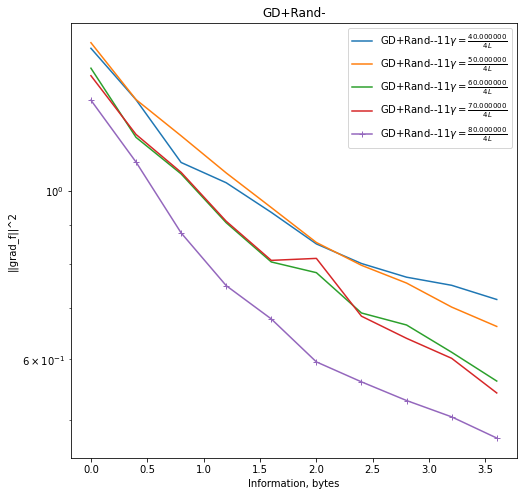

In [24]:
#LR fitting GD + Rand10%
title = "GD+Rand-"
n_iter = 10
compression_coeff = 0.1
c_param_list = [40, 50, 60, 70, 80]
x, y, labels, best_alg, best_information, best_differences_arr, best_label, best_idx, accs, best_points_arr = best_compressor_alg_loss(
                                            d_logloss_mushrooms, d_logloss_grad_mushrooms, title,
                                            n_iter, compression_coeff, c_param_list, y_lim = 1e-2, 
                                            rand_k_activate = True, top_k_activate = False, diana_activate = False, 
                                            ef_activate = False
                                            )
opt.plot_graphs(x, y, x_label = "Information, bytes", lines_labels = labels, title = title, logscale = True, criteria_type = "||grad_f||^2", idx_marker_arr = best_idx)

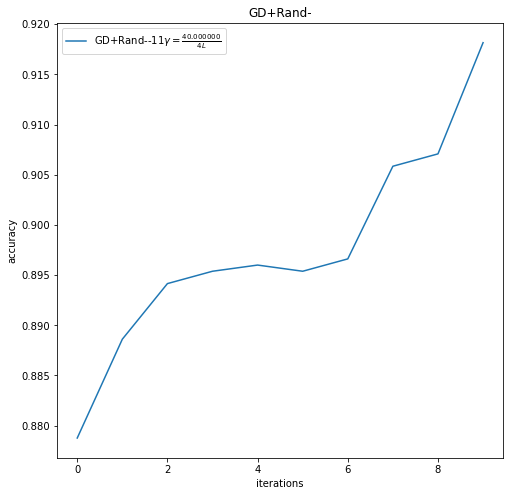

In [25]:
best_idx = best_idx[0]

X_acc.append([i for i in range(n_iter)])
Y_acc.append(accs[best_idx])
Labels_acc.append(labels[best_idx])
opt.plot_graphs(X_acc, Y_acc, x_label = "iterations", lines_labels = labels, 
                title = title, logscale = False, criteria_type = "accuracy", specific_slice=[specific_slice_num])

X_crit.append(x[best_idx]) 
Y_crit.append(y[best_idx]) 
Labels_crit.append(labels[best_idx]) 

specific_slice_num += 1

### LR choice for GD + Rand10%
- The function said that the best is when $c = 10$ works okay (in the picture there is $c = 0.001$ but I can't change it now because it requires some time)

100%|██████████| 100/100 [00:48<00:00,  2.06it/s]


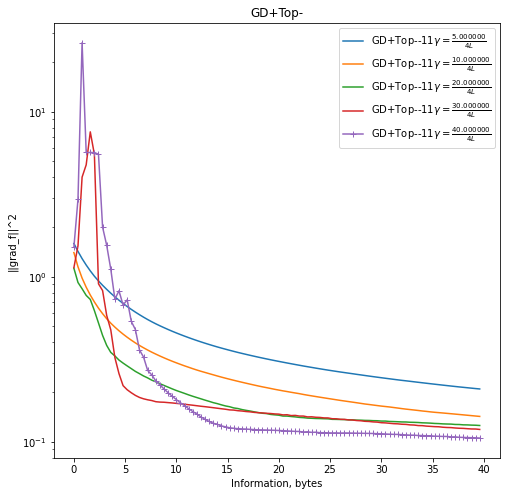

In [26]:
#LR fitting GD + Top-10%
title = "GD+Top-"
n_iter = 100
compression_coeff = 0.1
c_param_list = [5, 10, 20, 30, 40]
x, y, labels, best_alg, best_information, best_differences_arr, best_label, best_idx, accs, best_points_arr = best_compressor_alg_loss(
                                            d_logloss_mushrooms, d_logloss_grad_mushrooms, title,
                                            n_iter, compression_coeff, c_param_list, y_lim = 1e-2, 
                                            rand_k_activate = False, top_k_activate = True, diana_activate = False, 
                                            ef_activate = False
                                            )
opt.plot_graphs(x, y, x_label = "Information, bytes", lines_labels = labels, title = title, logscale = True, criteria_type = "||grad_f||^2", idx_marker_arr = best_idx)

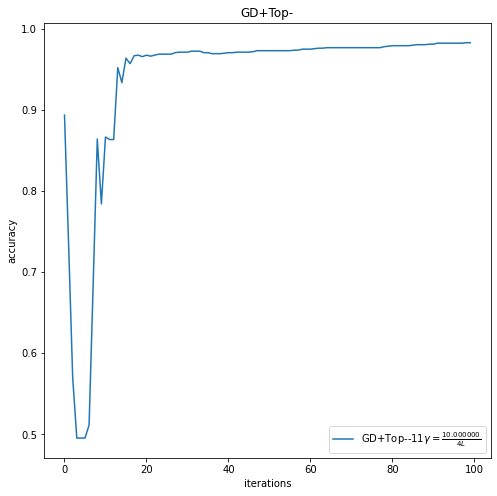

In [27]:
best_idx = best_idx[0] #1

X_acc.append([i for i in range(n_iter)])
Y_acc.append(accs[best_idx])
Labels_acc.append(labels[best_idx])
opt.plot_graphs(X_acc, Y_acc, x_label = "iterations", lines_labels = labels, 
                title = title, logscale = False, criteria_type = "accuracy", specific_slice=[specific_slice_num])

X_crit.append(x[best_idx]) 
Y_crit.append(y[best_idx]) 
Labels_crit.append(labels[best_idx]) 

specific_slice_num += 1

### LR choice for GD + Top10%
- The function said that the best is when $c = 10$ and I think it's okay

  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\HP\Desktop\МФТИ\S6\Optimization S2\HW\Kirill-Acharya-MIPT\my_optimization.py:125: ComplexWarning: Casting complex values to real discards the imaginary part
  compressed_grad[rand_indices] = grad[rand_indices]
c:\Users\HP\Desktop\МФТИ\S6\Optimization S2\HW\Kirill-Acharya-MIPT\my_optimization.py:159: ComplexWarning: Casting complex values to real discards the imaginary part
  errors_list[i] = errors_list[i] + gamma * grad_list[i] - displaced_grad_list[i]
100%|██████████| 100/100 [00:30<00:00,  3.33it/s]


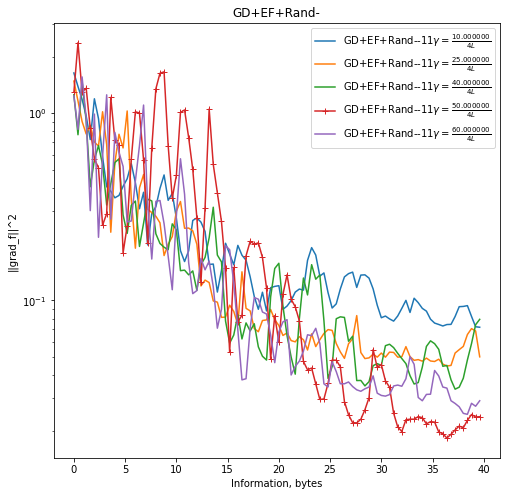

In [28]:
#LR fitting GD + Rand-10% + EF
title = "GD+EF+Rand-"
n_iter = 100
compression_coeff = 0.1
c_param_list = [10, 25, 40, 50, 60]
x, y, labels, best_alg, best_information, best_differences_arr, best_label, best_idx, accs, best_points_arr = best_compressor_alg_loss(
                                            d_logloss_mushrooms, d_logloss_grad_mushrooms, title,
                                            n_iter, compression_coeff, c_param_list, y_lim = 1e-2, 
                                            rand_k_activate = True, top_k_activate = False, diana_activate = False, 
                                            ef_activate = True
                                            )
opt.plot_graphs(x, y, x_label = "Information, bytes", lines_labels = labels, title = title, logscale = True, criteria_type = "||grad_f||^2", idx_marker_arr = best_idx)

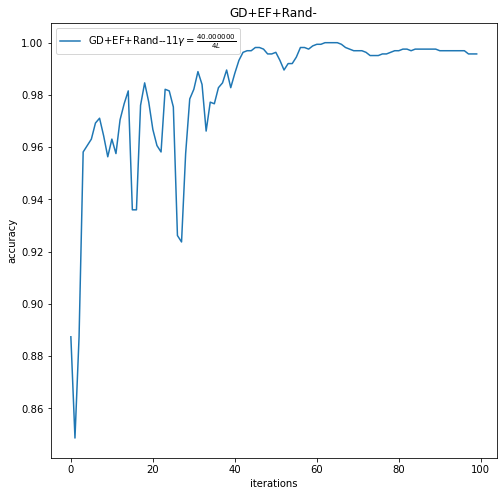

In [29]:
best_idx = best_idx[0]

X_acc.append([i for i in range(n_iter)])
Y_acc.append(accs[best_idx])
Labels_acc.append(labels[best_idx])
opt.plot_graphs(X_acc, Y_acc, x_label = "iterations", lines_labels = labels, 
                title = title, logscale = False, criteria_type = "accuracy", specific_slice=[specific_slice_num])

X_crit.append(x[best_idx]) 
Y_crit.append(y[best_idx]) 
Labels_crit.append(labels[best_idx]) 

specific_slice_num += 1

### LR choice for GD + Rand10% + EF
- Here I agree with the function again ($c = 50$), although the descent is not smooth

  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\HP\Desktop\МФТИ\S6\Optimization S2\HW\Kirill-Acharya-MIPT\my_optimization.py:111: ComplexWarning: Casting complex values to real discards the imaginary part
  compressed_grad[top_indices] = grad[top_indices]
 10%|█         | 10/100 [00:03<00:25,  3.51it/s]<ipython-input-21-05f870c057c0>:15: RuntimeWarning: overflow encountered in exp
  grad_j -= np.real(args['y_train_list'][j][i] * args['X_train_list'][j][i] * np.exp(- w.dot(args['X_train_list'][j][i]) * args["y_train_list"][j][i]) / (1 + np.exp(- w.dot(args['X_train_list'][j][i]) * args['X_train_list'][j][i])))
<ipython-input-21-05f870c057c0>:15: RuntimeWarning: invalid value encountered in multiply
  grad_j -= np.real(args['y_train_list'][j][i] * args['X_train_list'][j][i] * np.exp(- w.dot(args['X_train_list'][j][i]) * args["y_train_list"][j][i]) / (1 + np.exp(- w.dot(args['X_train_list'][j][i]) * args['X_train_list'][j][i])))
<ipython-input-21-05f870c057c0>:15: RuntimeWarning: invalid 

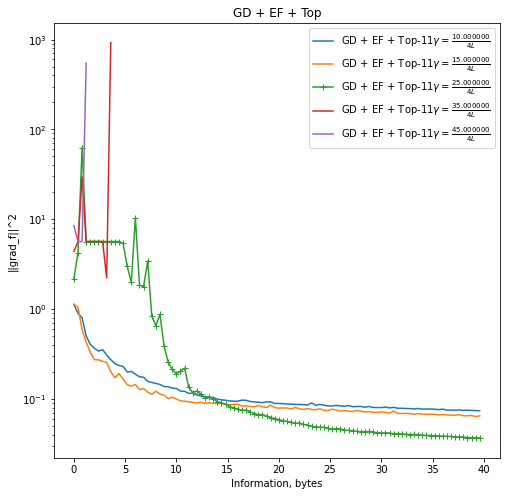

In [30]:
#LR fitting GD + Top-10% + EF
title = "GD + EF + Top"
n_iter = 100
compression_coeff = 0.1
c_param_list = [10, 15, 25, 35, 45]
x, y, labels, best_alg, best_information, best_differences_arr, best_label, best_idx, accs, best_points_arr = best_compressor_alg_loss(
                                            d_logloss_mushrooms, d_logloss_grad_mushrooms, title,
                                            n_iter, compression_coeff, c_param_list, y_lim = 1e-2, 
                                            rand_k_activate = False, top_k_activate = True, diana_activate = False, 
                                            ef_activate = True
                                            )
opt.plot_graphs(x, y, x_label = "Information, bytes", lines_labels = labels, title = title, logscale = True, criteria_type = "||grad_f||^2", idx_marker_arr = best_idx)

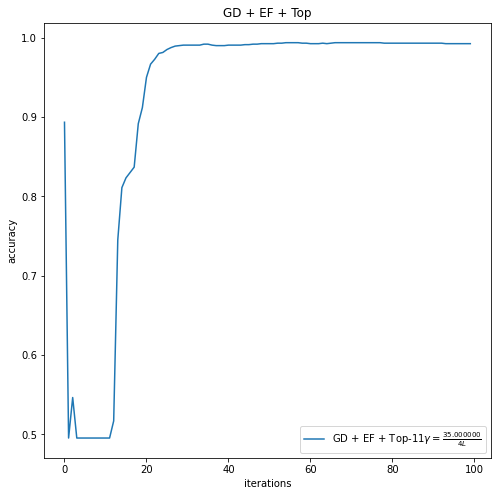

In [31]:
best_idx = best_idx[0]

X_acc.append([i for i in range(n_iter)])
Y_acc.append(accs[best_idx])
Labels_acc.append(labels[best_idx])
opt.plot_graphs(X_acc, Y_acc, x_label = "iterations", lines_labels = labels, 
                title = title, logscale = False, criteria_type = "accuracy", specific_slice=[specific_slice_num])

X_crit.append(x[best_idx]) 
Y_crit.append(y[best_idx]) 
Labels_crit.append(labels[best_idx]) 

specific_slice_num += 1

### LR choice for GD + Top10 + EF%
- The function said that the best is when $c = 10$ (see the choice criteria 1) and I agree with this statement

100%|██████████| 100/100 [00:46<00:00,  2.14it/s]


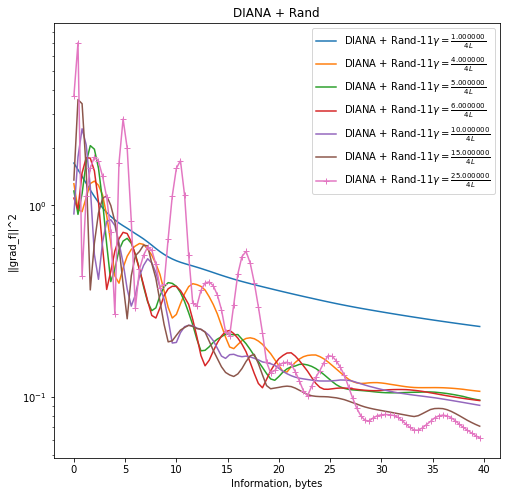

In [32]:
#LR fitting DIANA + Rand10%
title = "DIANA + Rand"
n_iter = 100
compression_coeff = 0.1
c_param_list = [1, 4, 5, 6, 10, 15, 25]
x, y, labels, best_alg, best_information, best_differences_arr, best_label, best_idx, accs, best_points_arr = best_compressor_alg_loss(
                                            d_logloss_mushrooms, d_logloss_grad_mushrooms, title,
                                            n_iter, compression_coeff, c_param_list, y_lim = 1e-2, 
                                            rand_k_activate = True, top_k_activate = False, diana_activate = True, 
                                            ef_activate = False
                                            )
opt.plot_graphs(x, y, x_label = "Information, bytes", lines_labels = labels, title = title, logscale = True, criteria_type = "||grad_f||^2", idx_marker_arr = best_idx)

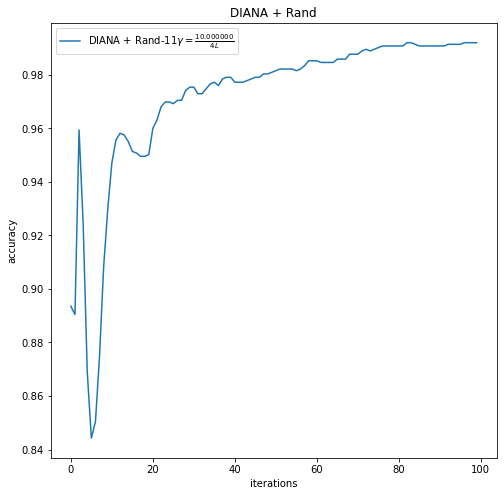

In [33]:
best_idx = best_idx[0]

X_acc.append([i for i in range(n_iter)])
Y_acc.append(accs[best_idx])
Labels_acc.append(labels[best_idx])
opt.plot_graphs(X_acc, Y_acc, x_label = "iterations", lines_labels = labels, 
                title = title, logscale = False, criteria_type = "accuracy", specific_slice=[specific_slice_num])

X_crit.append(x[best_idx]) 
Y_crit.append(y[best_idx]) 
Labels_crit.append(labels[best_idx]) 

specific_slice_num += 1

### LR choice for DIANA + Rand10%
- The function said that the best is when $c = 10$ (see the choice criteria 1) but I'll probably choose something between $c = 1$ and $c = 10$, because it is a bit unstable at the start, although it is more stable at the end

 18%|█▊        | 18/100 [00:14<00:54,  1.51it/s]<ipython-input-21-05f870c057c0>:15: RuntimeWarning: overflow encountered in exp
  grad_j -= np.real(args['y_train_list'][j][i] * args['X_train_list'][j][i] * np.exp(- w.dot(args['X_train_list'][j][i]) * args["y_train_list"][j][i]) / (1 + np.exp(- w.dot(args['X_train_list'][j][i]) * args['X_train_list'][j][i])))
 59%|█████▉    | 59/100 [00:38<00:25,  1.60it/s]<ipython-input-21-05f870c057c0>:15: RuntimeWarning: invalid value encountered in multiply
  grad_j -= np.real(args['y_train_list'][j][i] * args['X_train_list'][j][i] * np.exp(- w.dot(args['X_train_list'][j][i]) * args["y_train_list"][j][i]) / (1 + np.exp(- w.dot(args['X_train_list'][j][i]) * args['X_train_list'][j][i])))
<ipython-input-21-05f870c057c0>:15: RuntimeWarning: invalid value encountered in true_divide
  grad_j -= np.real(args['y_train_list'][j][i] * args['X_train_list'][j][i] * np.exp(- w.dot(args['X_train_list'][j][i]) * args["y_train_list"][j][i]) / (1 + np.exp(- w.dot(ar

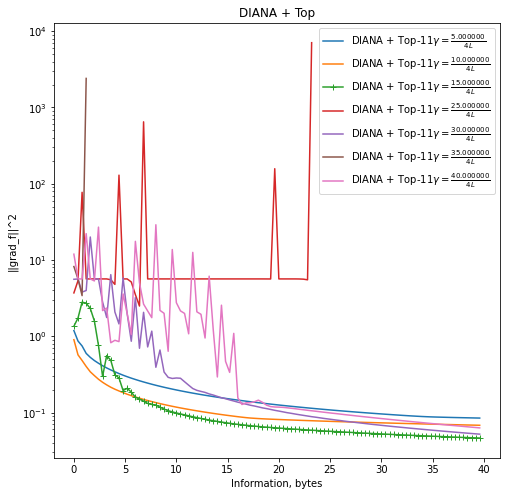

In [34]:
#LR fitting DIANA + Top10%
title = "DIANA + Top"
n_iter = 100
compression_coeff = 0.1
c_param_list = [5, 10, 15, 25, 30, 35, 40]
x, y, labels, best_alg, best_information, best_differences_arr, best_label, best_idx, accs, best_points_arr = best_compressor_alg_loss(
                                            d_logloss_mushrooms, d_logloss_grad_mushrooms, title,
                                            n_iter, compression_coeff, c_param_list, y_lim = 1e-2, 
                                            rand_k_activate = False, top_k_activate = True, diana_activate = True, 
                                            ef_activate = False
                                            )
opt.plot_graphs(x, y, x_label = "Information, bytes", lines_labels = labels, title = title, logscale = True, criteria_type = "||grad_f||^2", idx_marker_arr = best_idx)

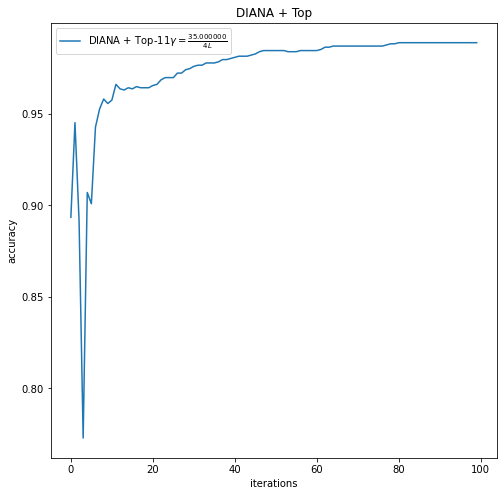

In [35]:
best_idx = best_idx[0]

X_acc.append([i for i in range(n_iter)])
Y_acc.append(accs[best_idx])
Labels_acc.append(labels[best_idx])
opt.plot_graphs(X_acc, Y_acc, x_label = "iterations", lines_labels = labels, 
                title = title, logscale = False, criteria_type = "accuracy", specific_slice=[specific_slice_num])

X_crit.append(x[best_idx]) 
Y_crit.append(y[best_idx]) 
Labels_crit.append(labels[best_idx]) 

specific_slice_num += 1

### LR choice for DIANA + Top10%
- The function said that the best is when $c = 10$ is the best here

### Comparison in terms of Criterium and Accuracy

I forgot to change the namings but we still have the order they came in

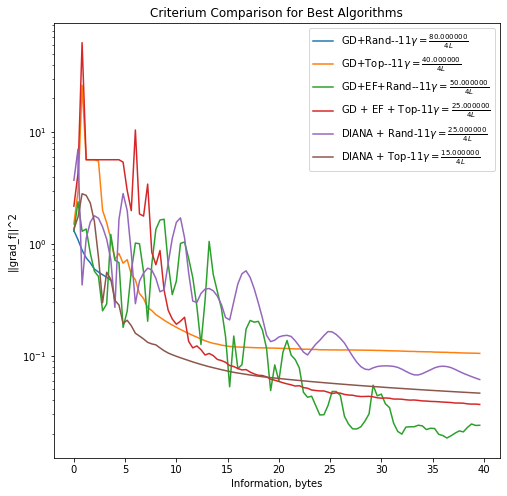

In [36]:
opt.plot_graphs(X_crit, Y_crit, x_label = "Information, bytes", lines_labels = Labels_crit, 
                title = "Criterium Comparison for Best Algorithms", logscale = True, criteria_type = "||grad_f||^2")

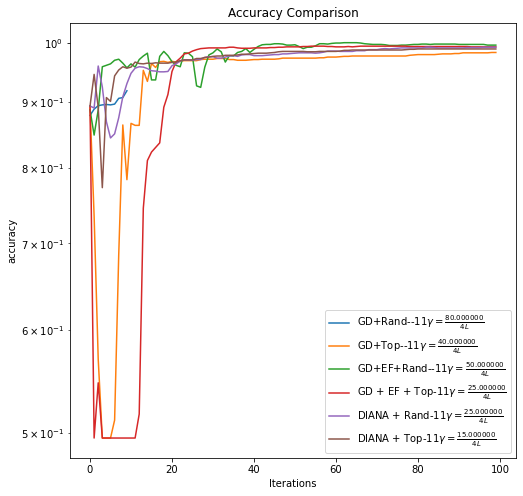

In [37]:
opt.plot_graphs(X_acc, Y_acc, x_label = "Iterations", lines_labels = Labels_acc, title = "Accuracy Comparison", 
                logscale = True, criteria_type = "accuracy")

### Conclusion
TBD

__Бонусные пункты__

__(г)__ Реализуйте два метода: [EF21](https://proceedings.neurips.cc/paper/2021/hash/231141b34c82aa95e48810a9d1b33a79-Abstract.html) и [MARINA](https://arxiv.org/abs/2102.07845). Добавьте их к сравнительному анализу из пункта (в) (здесь важно обратить внимание на особенности алгоритма MARINA и отразить это в анализе). Сделайте вывод. 

100%|██████████| 100/100 [00:44<00:00,  2.23it/s]


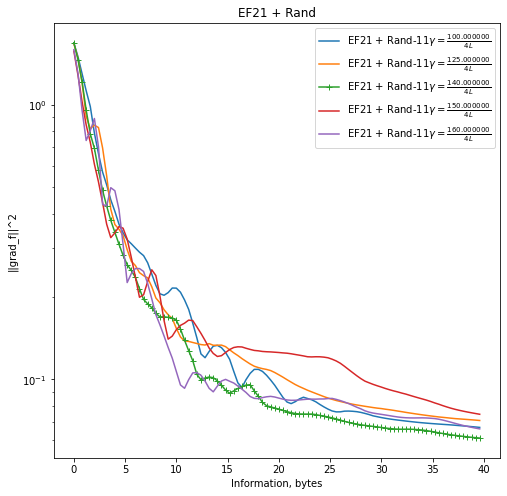

In [38]:
#LR fitting EF21 + Rand10%
title = "EF21 + Rand"
n_iter = 100
compression_coeff = 0.1
c_param_list = [100, 125, 140, 150, 160]
x, y, labels, best_alg, best_information, best_differences_arr, best_label, best_idx, accs, best_points_arr = best_compressor_alg_loss(
                                            d_logloss_mushrooms, d_logloss_grad_mushrooms, title,
                                            n_iter, compression_coeff, c_param_list, y_lim = 1e-2, 
                                            rand_k_activate = True, top_k_activate = False, ef21_activate = True
                                            )
opt.plot_graphs(x, y, x_label = "Information, bytes", lines_labels = labels, title = title, logscale = True, criteria_type = "||grad_f||^2", idx_marker_arr = best_idx)

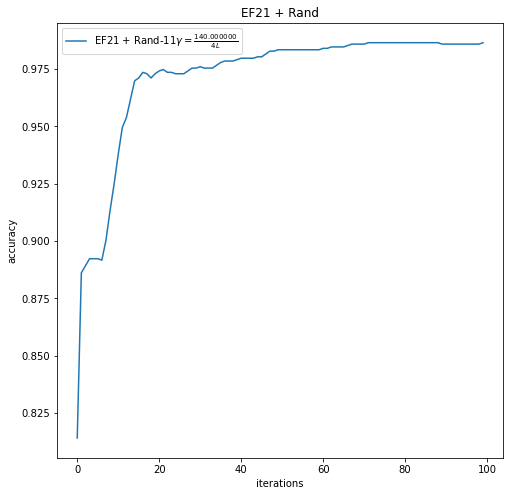

In [48]:
best_idx = best_idx

X_acc.append([i for i in range(n_iter)])
Y_acc.append(accs[best_idx])
Labels_acc.append(labels[best_idx])
opt.plot_graphs(X_acc, Y_acc, x_label = "iterations", lines_labels = Labels_acc, 
                title = title, logscale = False, criteria_type = "accuracy", specific_slice=[specific_slice_num])

X_crit.append(x[best_idx]) 
Y_crit.append(y[best_idx]) 
Labels_crit.append(labels[best_idx]) 

specific_slice_num += 1

100%|██████████| 100/100 [00:49<00:00,  2.03it/s]


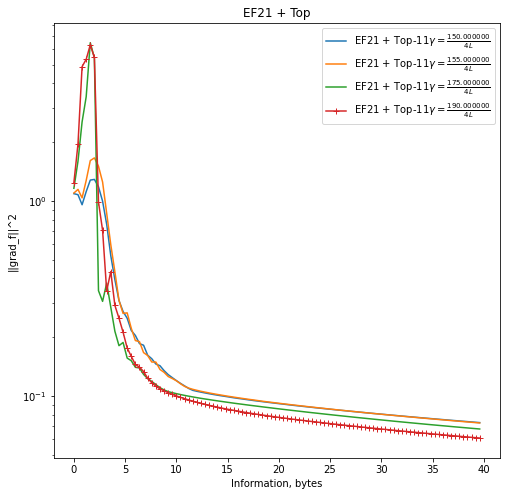

In [49]:
#LR fitting EF21 + Top10%
title = "EF21 + Top"
n_iter = 100
compression_coeff = 0.1
c_param_list = [150, 155, 175, 190, 225]
x, y, labels, best_alg, best_information, best_differences_arr, best_label, best_idx, accs, best_points_arr = best_compressor_alg_loss(
                                            d_logloss_mushrooms, d_logloss_grad_mushrooms, title,
                                            n_iter, compression_coeff, c_param_list, y_lim = 1e-2, 
                                            rand_k_activate = False, top_k_activate = True, diana_activate = False, 
                                            ef_activate = False, ef21_activate = True
                                            )
opt.plot_graphs(x, y, x_label = "Information, bytes", lines_labels = labels, title = title, logscale = True, criteria_type = "||grad_f||^2", idx_marker_arr = best_idx)

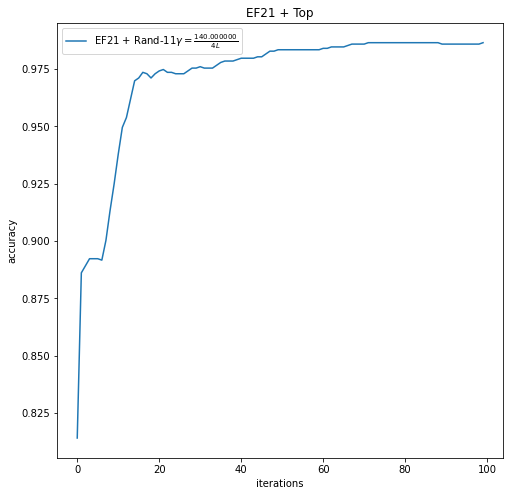

In [52]:
best_idx = best_idx

X_acc.append([i for i in range(n_iter)])
Y_acc.append(accs[best_idx])
Labels_acc.append(labels[best_idx])
opt.plot_graphs(X_acc, Y_acc, x_label = "iterations", lines_labels = Labels_acc, 
                title = title, logscale = False, criteria_type = "accuracy", specific_slice=[specific_slice_num])

X_crit.append(x[best_idx]) 
Y_crit.append(y[best_idx]) 
Labels_crit.append(labels[best_idx]) 

specific_slice_num += 1

In [58]:
#LR fitting Marina + Rand10%%
title = "Marina + Rand"
n_iter = 10
compression_coeff = 0.1
c_param_list = [1, 5, 8]
x, y, labels, best_alg, best_information, best_differences_arr, best_label, best_idx, accs, best_points_arr = best_compressor_alg_loss(
                                            d_logloss_mushrooms, d_logloss_grad_mushrooms, title,
                                            n_iter, compression_coeff, c_param_list, y_lim = 1e-2, 
                                            rand_k_activate = True, top_k_activate = False, marina_activate = True,
                                            )

 50%|█████     | 5/10 [00:26<00:26,  5.39s/it]


KeyboardInterrupt: 

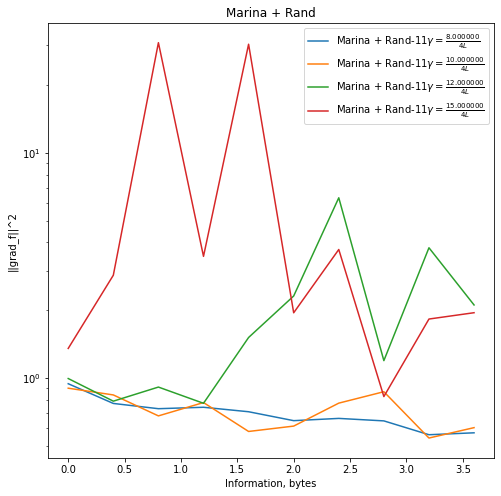

In [57]:
opt.plot_graphs(x, y, x_label = "Information, bytes", lines_labels = labels, title = title, logscale = True, criteria_type = "||grad_f||^2", idx_marker_arr = best_idx, specific_slice=[0, 1, 2, 3])

In [ ]:
best_idx = best_idx[0]

X_acc.append([i for i in range(n_iter)])
Y_acc.append(accs[best_idx])
Labels_acc.append(labels[best_idx])
opt.plot_graphs(X_acc, Y_acc, x_label = "iterations", lines_labels = labels, 
                title = title, logscale = False, criteria_type = "accuracy", specific_slice=[specific_slice_num])

X_crit.append(x[best_idx]) 
Y_crit.append(y[best_idx]) 
Labels_crit.append(labels[best_idx]) 

specific_slice_num += 1

NameError: name 'specific_slice_num' is not defined

In [ ]:
#LR fitting Marina + Top10%%
title = "Marina + Top"
n_iter = 10
compression_coeff = 0.1
c_param_list = [5, 8, 10, 15, 20]
x, y, labels, best_alg, best_information, best_differences_arr, best_label, best_idx, accs, best_points_arr = best_compressor_alg_loss(
                                            d_logloss_mushrooms, d_logloss_grad_mushrooms, title,
                                            n_iter, compression_coeff, c_param_list, y_lim = 1e-2, 
                                            rand_k_activate = False, top_k_activate = True, marina_activate = True,
                                            )
opt.plot_graphs(x, y, x_label = "Information, bytes", lines_labels = labels, title = title, logscale = True, criteria_type = "||grad_f||^2", idx_marker_arr = best_idx)

In [ ]:
best_idx = best_idx[0]

X_acc.append([i for i in range(n_iter)])
Y_acc.append(accs[best_idx])
Labels_acc.append(labels[best_idx])
opt.plot_graphs(X_acc, Y_acc, x_label = "iterations", lines_labels = labels, 
                title = title, logscale = False, criteria_type = "accuracy", specific_slice=[specific_slice_num])

X_crit.append(x[best_idx]) 
Y_crit.append(y[best_idx]) 
Labels_crit.append(labels[best_idx]) 

specific_slice_num += 1

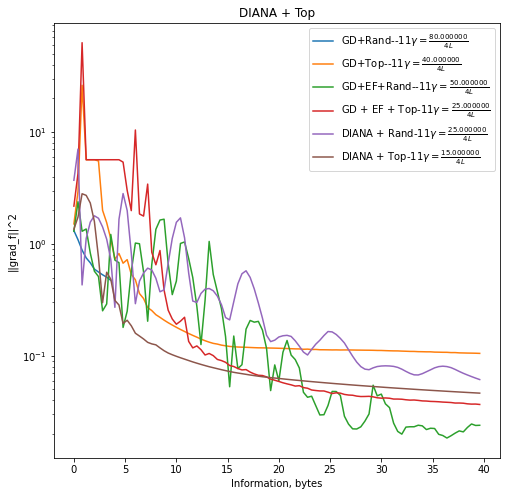

In [ ]:
#Final convergence to compare
Acc_labels = []
for i in range(8):
    Acc_labels.append(Labels_crit[2*i])
opt.plot_graphs(X_crit, Y_crit, x_label = "Information, bytes", lines_labels=Acc_labels, title = title, logscale = True, 
                criteria_type = "||grad_f||^2")


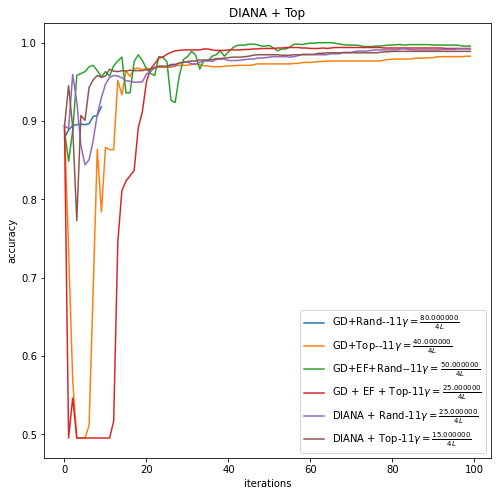

In [ ]:
#Final accuracies to compare
opt.plot_graphs(X_acc, Y_acc, x_label = "iterations", lines_labels = Acc_labels, title = title, logscale = False,
                 criteria_type = "accuracy")


__(д)__ Добавьте в лучшие 3 (на Ваш взгляд) метода (обычный GD с оператором сжатия, GD с EF, DIANA, EF21, MARINA) возможность сжимать и при передаче от сервера к устройству. Для сжатия используйте только $\text{Top}10\%$ и $\text{Rand}10\%$. Проведите серию экспериментов и ответьте на следующие пункты:

1) Если при сжатии на сервере используются $\text{Top}10\%$ нужно ли использовать технику компесации ошибки на сервере? Опишите, как добавляли еe в метод (лучший вариант - выписать алгоритм частично или целиком). 

2) Перебирая разные комбинации из операторов $\text{Top}10\%$ и $\text{Rand}10\%$ для сжатия на сервера и на устройствах, найдите лучшую конфигурацию операторов сжатия для каждого метода.

3) Какой метод и с каким операторами показал в итоге лучшие результаты? Использовался ли при этом дополнительный error feedback на сервере? 

In [ ]:
#TBD